## 1. Setup Spark Session

In [1]:
from pyspark.sql import SparkSession
import os
import sys
import platform
from pathlib import Path

# Import Windows Hadoop setup from test_local.py if needed
if platform.system() == 'Windows':
    # Set up Hadoop for Windows
    workspace_root = Path.cwd()
    hadoop_home = workspace_root / 'hadoop'
    hadoop_bin = hadoop_home / 'bin'
    
    if hadoop_home.exists():
        os.environ['HADOOP_HOME'] = str(hadoop_home)
        os.environ['hadoop.home.dir'] = str(hadoop_home)
        if str(hadoop_bin) not in os.environ['PATH']:
            os.environ['PATH'] = str(hadoop_bin) + os.pathsep + os.environ['PATH']

# Initialize Spark with Delta Lake
spark = SparkSession.builder \
    .appName("DataMesh-Explorer") \
    .config("spark.jars.packages", "io.delta:delta-core_2.12:2.4.0") \
    .config("spark.sql.extensions", "io.delta.sql.DeltaSparkSessionExtension") \
    .config("spark.sql.catalog.spark_catalog", "org.apache.spark.sql.delta.catalog.DeltaCatalog") \
    .master("local[*]") \
    .getOrCreate()

# Suppress verbose logging
spark.sparkContext.setLogLevel("ERROR")

print(f"✓ Spark {spark.version} initialized")
print(f"✓ Working directory: {Path.cwd()}")

✓ Spark 3.4.1 initialized
✓ Working directory: c:\Users\0034474\OneDrive - DEME\Desktop\data-mesh-reference-implementation


## 2. Load Delta Tables

In [2]:
# Load Sales domain tables
sales_bronze = spark.read.format("delta").load("output/bronze/sales/orders")
sales_silver = spark.read.format("delta").load("output/silver/sales/orders")
sales_gold = spark.read.format("delta").load("output/gold/sales/daily_revenue")

# Load Research Ops domain tables
research_bronze = spark.read.format("delta").load("output/bronze/research_ops/experiments")
research_silver = spark.read.format("delta").load("output/silver/research_ops/experiments")
research_gold = spark.read.format("delta").load("output/gold/research_ops/daily_metrics")

print("✓ All Delta tables loaded successfully")

✓ All Delta tables loaded successfully


## 3. Sales Domain - Data Exploration

### Sales Bronze Layer (Raw Data)

In [3]:
print(f"Row count: {sales_bronze.count()}")
print("\nSchema:")
sales_bronze.printSchema()
print("\nSample data:")
sales_bronze.show(truncate=False)

Row count: 4

Schema:
root
 |-- order_id: integer (nullable = true)
 |-- order_date: date (nullable = true)
 |-- customer_id: string (nullable = true)
 |-- product: string (nullable = true)
 |-- quantity: integer (nullable = true)
 |-- unit_price: integer (nullable = true)
 |-- currency: string (nullable = true)
 |-- _ingestion_timestamp: timestamp (nullable = true)
 |-- _source_file: string (nullable = true)
 |-- _ingestion_date: date (nullable = true)


Sample data:
+--------+----------+-----------+--------+--------+----------+--------+--------------------------+-----------------------------------------------+---------------+
|order_id|order_date|customer_id|product |quantity|unit_price|currency|_ingestion_timestamp      |_source_file                                   |_ingestion_date|
+--------+----------+-----------+--------+--------+----------+--------+--------------------------+-----------------------------------------------+---------------+
|1001    |2025-01-01|C001       |Lapto

### Sales Silver Layer (Validated Data)

In [4]:
print(f"Row count: {sales_silver.count()}")
print("\nSample data:")
sales_silver.show(truncate=False)

Row count: 3

Sample data:
+--------+----------+-----------+--------+--------+----------+--------+--------------------------+-----------------------------------------------+---------------+
|order_id|order_date|customer_id|product |quantity|unit_price|currency|_ingestion_timestamp      |_source_file                                   |_ingestion_date|
+--------+----------+-----------+--------+--------+----------+--------+--------------------------+-----------------------------------------------+---------------+
|1001    |2025-01-01|C001       |Laptop  |1       |1200.00   |EUR     |2025-12-17 13:57:37.166629|domains/sales/sample_data/orders_2025-01-01.csv|2025-12-17     |
|1002    |2025-01-01|C002       |Mouse   |2       |25.00     |EUR     |2025-12-17 13:57:37.166629|domains/sales/sample_data/orders_2025-01-01.csv|2025-12-17     |
|1003    |2025-01-01|C001       |Keyboard|1       |75.00     |EUR     |2025-12-17 13:57:37.166629|domains/sales/sample_data/orders_2025-01-01.csv|2025-12-17  

### Sales Gold Layer (Aggregated Metrics)

In [5]:
print("Daily Revenue Summary:")
sales_gold.show()

Daily Revenue Summary:
+----------+-------------+
|order_date|daily_revenue|
+----------+-------------+
|2025-01-01|      1325.00|
+----------+-------------+



## 4. Research Ops Domain - Data Exploration

### Research Ops Bronze Layer

In [6]:
print(f"Row count: {research_bronze.count()}")
print("\nSample data:")
research_bronze.show(truncate=False)

Row count: 4

Sample data:
+-------------+---------------+-----------+-------+----------------+-------------+--------------------------+-----------------------------------------------------------+---------------+
|experiment_id|experiment_date|trial_count|success|duration_minutes|researcher_id|_ingestion_timestamp      |_source_file                                               |_ingestion_date|
+-------------+---------------+-----------+-------+----------------+-------------+--------------------------+-----------------------------------------------------------+---------------+
|EXP001       |2025-01-01     |50         |true   |42              |R001         |2025-12-17 13:58:34.750693|domains/research_ops/sample_data/experiments_2025-01-01.csv|2025-12-17     |
|EXP002       |2025-01-01     |50         |true   |48              |R002         |2025-12-17 13:58:34.750693|domains/research_ops/sample_data/experiments_2025-01-01.csv|2025-12-17     |
|EXP003       |2025-01-01     |50         |

### Research Ops Silver Layer

In [7]:
print(f"Row count: {research_silver.count()}")
print("\nSample data:")
research_silver.show(truncate=False)

Row count: 4

Sample data:
+-------------+---------------+-----------+-------+----------------+-------------+--------------------------+-----------------------------------------------------------+---------------+
|experiment_id|experiment_date|trial_count|success|duration_minutes|researcher_id|_ingestion_timestamp      |_source_file                                               |_ingestion_date|
+-------------+---------------+-----------+-------+----------------+-------------+--------------------------+-----------------------------------------------------------+---------------+
|EXP001       |2025-01-01     |50         |true   |42.00           |R001         |2025-12-17 13:58:34.750693|domains/research_ops/sample_data/experiments_2025-01-01.csv|2025-12-17     |
|EXP002       |2025-01-01     |50         |true   |48.00           |R002         |2025-12-17 13:58:34.750693|domains/research_ops/sample_data/experiments_2025-01-01.csv|2025-12-17     |
|EXP003       |2025-01-01     |50         |

### Research Ops Gold Layer

In [8]:
print("Daily Experiment Metrics:")
research_gold.show()

Daily Experiment Metrics:
+---------------+------------+----------------+--------------------+
|experiment_date|total_trials|experiment_count|avg_duration_minutes|
+---------------+------------+----------------+--------------------+
|     2025-01-01|         200|               4|           44.250000|
+---------------+------------+----------------+--------------------+



## 5. Data Visualizations with Pandas and Matplotlib

In [13]:
import pandas as pd
import matplotlib.pyplot as plt

# Configure pandas to use pyarrow for better datetime handling
spark.conf.set("spark.sql.execution.arrow.pyspark.enabled", "true")

# Convert Spark DataFrames to Pandas for visualization
sales_df = sales_silver.toPandas()
research_df = research_silver.toPandas()

# Display column info for debugging
print("Sales columns:", sales_df.columns.tolist())
print("Sales data types:\n", sales_df.dtypes)
print("\nResearch columns:", research_df.columns.tolist())
print("\n✓ Data converted to Pandas DataFrames")

Sales columns: ['order_id', 'order_date', 'customer_id', 'product', 'quantity', 'unit_price', 'currency', '_ingestion_timestamp', '_source_file', '_ingestion_date']
Sales data types:
 order_id                         int32
order_date                      object
customer_id                     object
product                         object
quantity                         int32
unit_price                      object
currency                        object
_ingestion_timestamp    datetime64[us]
_source_file                    object
_ingestion_date                 object
dtype: object

Research columns: ['experiment_id', 'experiment_date', 'trial_count', 'success', 'duration_minutes', 'researcher_id', '_ingestion_timestamp', '_source_file', '_ingestion_date']

✓ Data converted to Pandas DataFrames


### Sales Analysis Visualizations

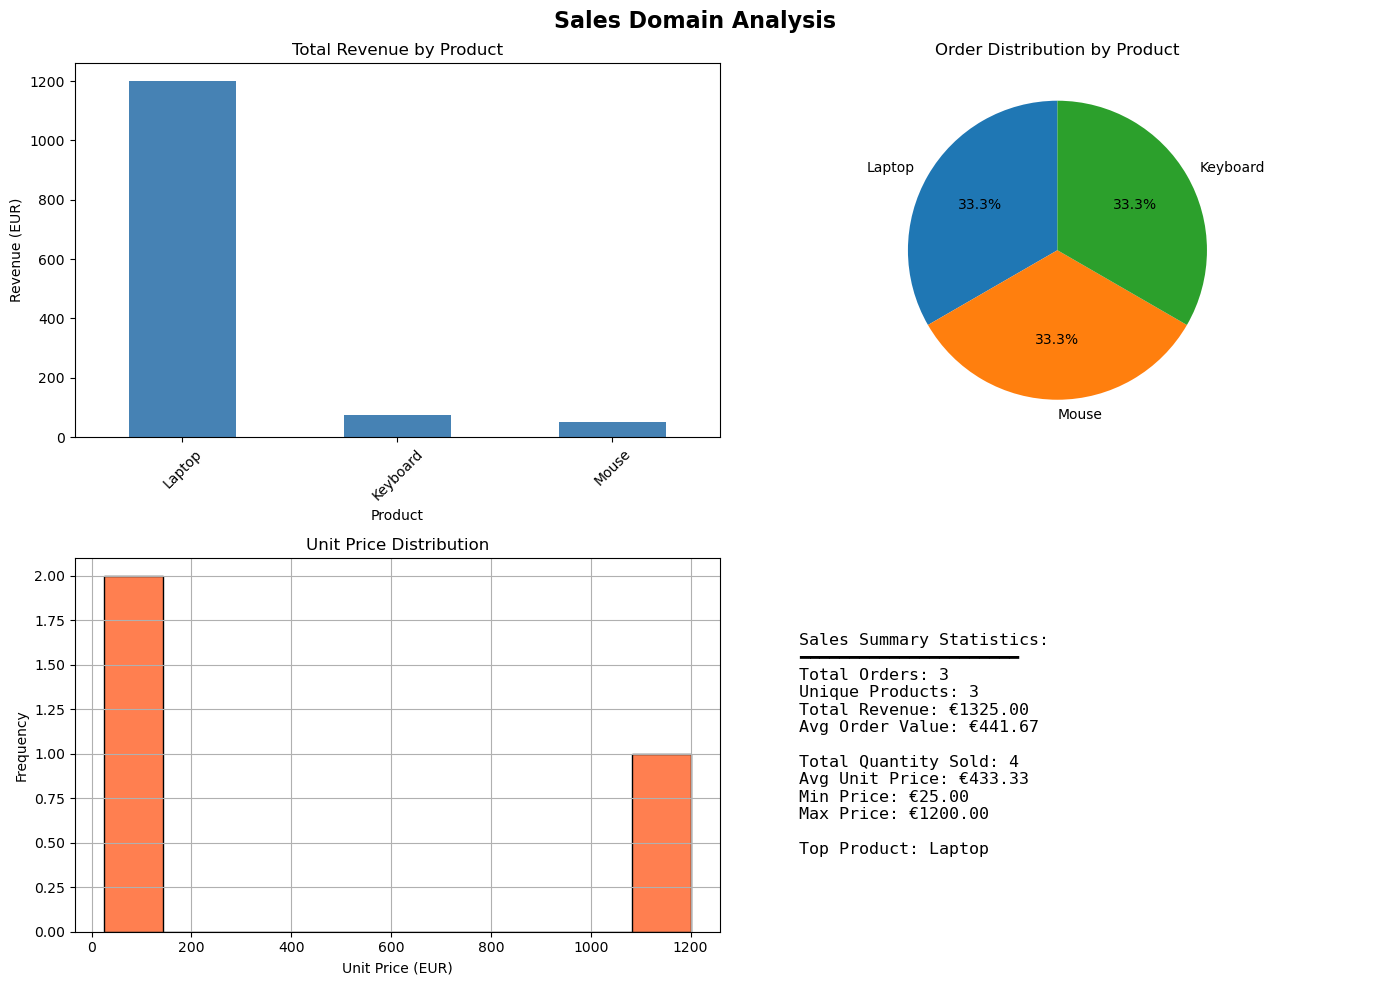

In [16]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Sales Domain Analysis', fontsize=16, fontweight='bold')

# Convert unit_price to numeric (it comes as object/string from Spark)
sales_df['unit_price'] = pd.to_numeric(sales_df['unit_price'])

# Calculate total amount per order
sales_df['total_amount'] = sales_df['quantity'] * sales_df['unit_price']

# 1. Revenue by Product
ax1 = axes[0, 0]
product_revenue = sales_df.groupby('product')['total_amount'].sum().sort_values(ascending=False)
product_revenue.plot(kind='bar', ax=ax1, color='steelblue')
ax1.set_title('Total Revenue by Product')
ax1.set_xlabel('Product')
ax1.set_ylabel('Revenue (EUR)')
ax1.tick_params(axis='x', rotation=45)

# 2. Orders by Product (Count)
ax2 = axes[0, 1]
product_counts = sales_df['product'].value_counts()
product_counts.plot(kind='pie', ax=ax2, autopct='%1.1f%%', startangle=90)
ax2.set_title('Order Distribution by Product')
ax2.set_ylabel('')

# 3. Unit Price Distribution
ax3 = axes[1, 0]
sales_df['unit_price'].hist(bins=10, ax=ax3, color='coral', edgecolor='black')
ax3.set_title('Unit Price Distribution')
ax3.set_xlabel('Unit Price (EUR)')
ax3.set_ylabel('Frequency')

# 4. Summary Statistics
ax4 = axes[1, 1]
ax4.axis('off')
stats_text = f"""
Sales Summary Statistics:
━━━━━━━━━━━━━━━━━━━━━━
Total Orders: {len(sales_df)}
Unique Products: {sales_df['product'].nunique()}
Total Revenue: €{sales_df['total_amount'].sum():.2f}
Avg Order Value: €{sales_df['total_amount'].mean():.2f}

Total Quantity Sold: {sales_df['quantity'].sum()}
Avg Unit Price: €{sales_df['unit_price'].mean():.2f}
Min Price: €{sales_df['unit_price'].min():.2f}
Max Price: €{sales_df['unit_price'].max():.2f}

Top Product: {product_revenue.index[0]}
"""
ax4.text(0.1, 0.5, stats_text, fontsize=12, family='monospace',
         verticalalignment='center')

plt.tight_layout()
plt.show()


### Research Ops Analysis Visualizations

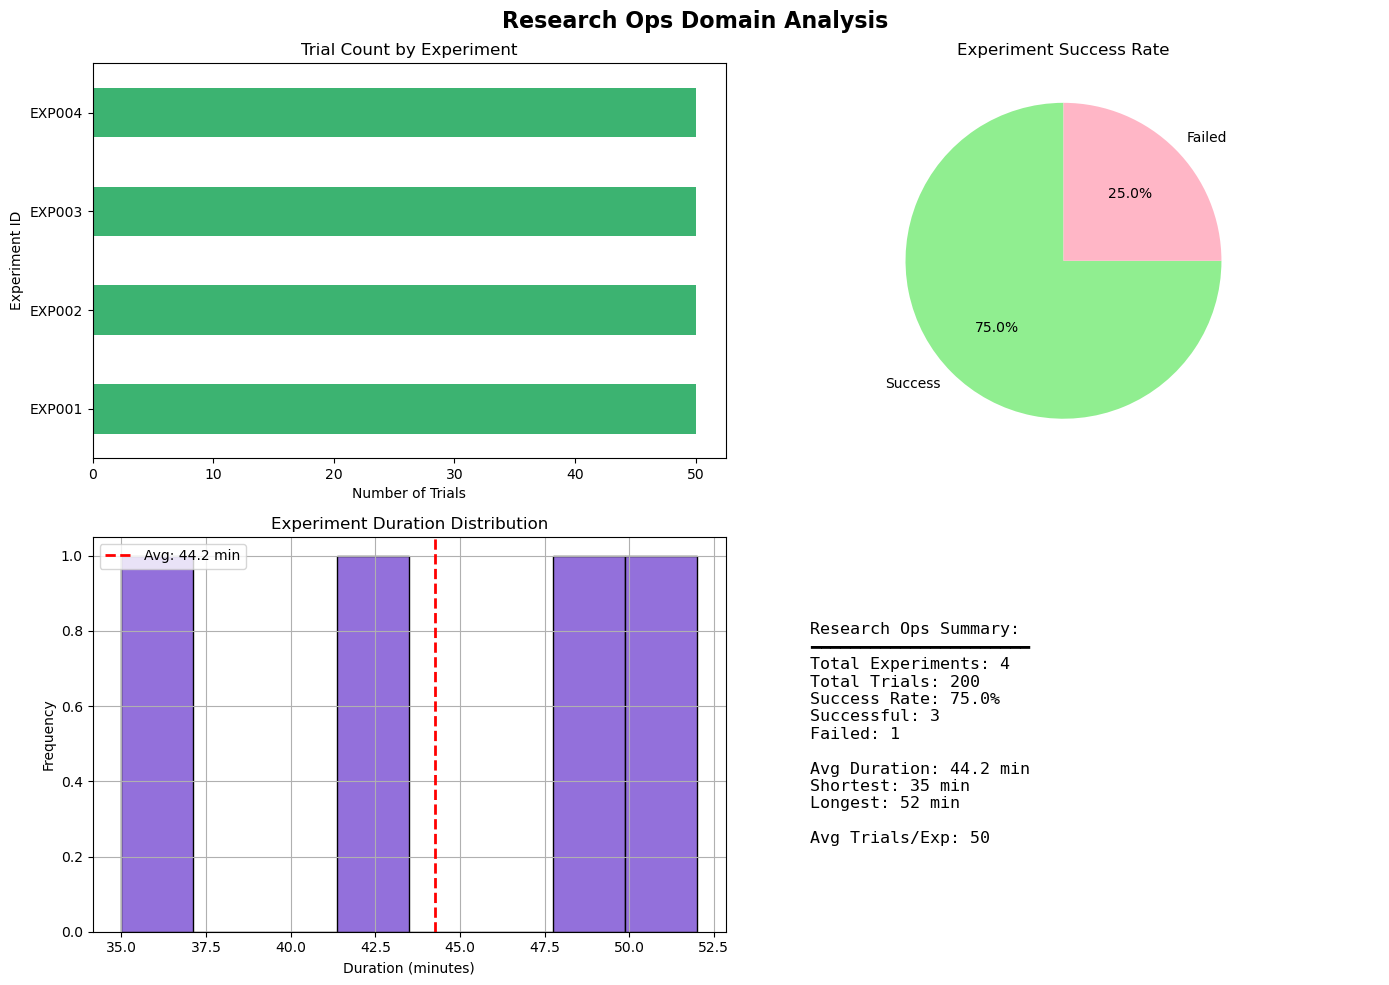

In [17]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Research Ops Domain Analysis', fontsize=16, fontweight='bold')

# Convert duration_minutes to numeric (it comes as object/string from Spark)
research_df['duration_minutes'] = pd.to_numeric(research_df['duration_minutes'])

# 1. Trials by Experiment
ax1 = axes[0, 0]
experiment_trials = research_df.groupby('experiment_id')['trial_count'].first().sort_values(ascending=False)
experiment_trials.plot(kind='barh', ax=ax1, color='mediumseagreen')
ax1.set_title('Trial Count by Experiment')
ax1.set_xlabel('Number of Trials')
ax1.set_ylabel('Experiment ID')

# 2. Success Status Distribution
ax2 = axes[0, 1]
success_counts = research_df['success'].value_counts()
success_counts.plot(kind='pie', ax=ax2, autopct='%1.1f%%', startangle=90, 
                    labels=['Success', 'Failed'], colors=['#90EE90', '#FFB6C6'])
ax2.set_title('Experiment Success Rate')
ax2.set_ylabel('')

# 3. Duration Distribution
ax3 = axes[1, 0]
research_df['duration_minutes'].hist(bins=8, ax=ax3, color='mediumpurple', edgecolor='black')
ax3.set_title('Experiment Duration Distribution')
ax3.set_xlabel('Duration (minutes)')
ax3.set_ylabel('Frequency')
ax3.axvline(research_df['duration_minutes'].mean(), color='red', linestyle='--', 
            linewidth=2, label=f"Avg: {research_df['duration_minutes'].mean():.1f} min")
ax3.legend()

# 4. Summary Statistics
ax4 = axes[1, 1]
ax4.axis('off')
successful = research_df[research_df['success'] == True]
failed = research_df[research_df['success'] == False]
success_rate = (len(successful) / len(research_df)) * 100 if len(research_df) > 0 else 0

stats_text = f"""
Research Ops Summary:
━━━━━━━━━━━━━━━━━━━━━━
Total Experiments: {len(research_df)}
Total Trials: {research_df['trial_count'].sum()}
Success Rate: {success_rate:.1f}%
Successful: {len(successful)}
Failed: {len(failed)}

Avg Duration: {research_df['duration_minutes'].mean():.1f} min
Shortest: {research_df['duration_minutes'].min():.0f} min
Longest: {research_df['duration_minutes'].max():.0f} min

Avg Trials/Exp: {research_df['trial_count'].mean():.0f}
"""
ax4.text(0.1, 0.5, stats_text, fontsize=12, family='monospace',
         verticalalignment='center')

plt.tight_layout()
plt.show()


## 6. Advanced Analytics with Spark SQL

In [18]:
# Register tables for SQL queries
sales_silver.createOrReplaceTempView("sales")
research_silver.createOrReplaceTempView("experiments")

print("✓ Tables registered for SQL queries")

✓ Tables registered for SQL queries


### SQL Query: Top Products by Revenue

In [19]:
query = """
SELECT 
    product,
    COUNT(*) as order_count,
    SUM(quantity) as total_quantity,
    SUM(quantity * unit_price) as total_revenue,
    AVG(unit_price) as avg_unit_price,
    MAX(unit_price) as max_unit_price
FROM sales
GROUP BY product
ORDER BY total_revenue DESC
"""

spark.sql(query).show()


+--------+-----------+--------------+-------------+--------------+--------------+
| product|order_count|total_quantity|total_revenue|avg_unit_price|max_unit_price|
+--------+-----------+--------------+-------------+--------------+--------------+
|  Laptop|          1|             1|      1200.00|   1200.000000|       1200.00|
|Keyboard|          1|             1|        75.00|     75.000000|         75.00|
|   Mouse|          1|             2|        50.00|     25.000000|         25.00|
+--------+-----------+--------------+-------------+--------------+--------------+



### SQL Query: Experiment Performance Ranking

In [20]:
query = """
SELECT 
    experiment_id,
    experiment_date,
    trial_count,
    success,
    duration_minutes,
    researcher_id,
    CASE 
        WHEN success = true AND duration_minutes < 45 THEN 'Excellent'
        WHEN success = true THEN 'Good'
        ELSE 'Needs Improvement'
    END as performance_rating
FROM experiments
ORDER BY success DESC, duration_minutes ASC
"""

spark.sql(query).show(truncate=False)


+-------------+---------------+-----------+-------+----------------+-------------+------------------+
|experiment_id|experiment_date|trial_count|success|duration_minutes|researcher_id|performance_rating|
+-------------+---------------+-----------+-------+----------------+-------------+------------------+
|EXP001       |2025-01-01     |50         |true   |42.00           |R001         |Excellent         |
|EXP002       |2025-01-01     |50         |true   |48.00           |R002         |Good              |
|EXP004       |2025-01-01     |50         |true   |52.00           |R003         |Good              |
|EXP003       |2025-01-01     |50         |false  |35.00           |R001         |Needs Improvement |
+-------------+---------------+-----------+-------+----------------+-------------+------------------+



## 7. Delta Lake Features

Explore Delta Lake-specific features like time travel and versioning.

In [22]:
# View Delta table history
print("Sales Silver Table History:")
spark.sql("DESCRIBE HISTORY 'output/silver/sales/orders'").select(
    "version", "timestamp", "operation", "operationMetrics"
).show(truncate=False)

print("\n" + "="*80 + "\n")

print("Research Ops Silver Table History:")
spark.sql("DESCRIBE HISTORY 'output/silver/research_ops/experiments'").select(
    "version", "timestamp", "operation", "operationMetrics"
).show(truncate=False)


Sales Silver Table History:
+-------+-----------------------+---------+-----------------------------------------------------------+
|version|timestamp              |operation|operationMetrics                                           |
+-------+-----------------------+---------+-----------------------------------------------------------+
|1      |2025-12-17 13:58:11.633|WRITE    |{numFiles -> 1, numOutputRows -> 3, numOutputBytes -> 3345}|
|0      |2025-12-17 13:51:59.825|WRITE    |{numFiles -> 1, numOutputRows -> 3, numOutputBytes -> 3345}|
+-------+-----------------------+---------+-----------------------------------------------------------+



Research Ops Silver Table History:
+-------+-----------------------+---------+-----------------------------------------------------------+
|version|timestamp              |operation|operationMetrics                                           |
+-------+-----------------------+---------+-----------------------------------------------------------